In [14]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:


# Verifique o nome exato do arquivo que apareceu na pasta
df = pd.read_csv('/Users/gustavocorreia/Documents/Repositories/Bitcoin_price/btcusd_1-min_data.csv')
print(df.info())


<class 'pandas.DataFrame'>
RangeIndex: 7399839 entries, 0 to 7399838
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 338.7 MB
None


In [4]:


# 1. Carregar colunas essenciais para poupar RAM
cols = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']


# 2. Converter Timestamp (UNIX) para Datetime real
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)

# 3. Tratar valores nulos (NaN)
# Em cripto, se não houve negociação no minuto, mantemos o preço anterior
df['Close'] = df['Close'].ffill() 
df['Open'] = df['Open'].fillna(df['Close'])
df['High'] = df['High'].fillna(df['Close'])
df['Low'] = df['Low'].fillna(df['Close'])
df['Volume'] = df['Volume'].fillna(0)

# 4. Resample: De Minutos para Dias ('D')
# Treinar um modelo minuto a minuto seria pesado demais e ruidoso
df_daily = df.resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print("Limpeza concluída!")
df_daily.head()

Limpeza concluída!


Open  High   Low  Close      Volume
Timestamp                                      
2012-01-01  4.58  4.84  4.58   4.84   10.000000
2012-01-02  4.84  5.00  4.84   5.00   10.100000
2012-01-03  5.00  5.32  5.00   5.29  107.085281
2012-01-04  5.29  5.57  4.93   5.57  107.233260
2012-01-05  5.57  6.46  5.57   6.42   70.328742

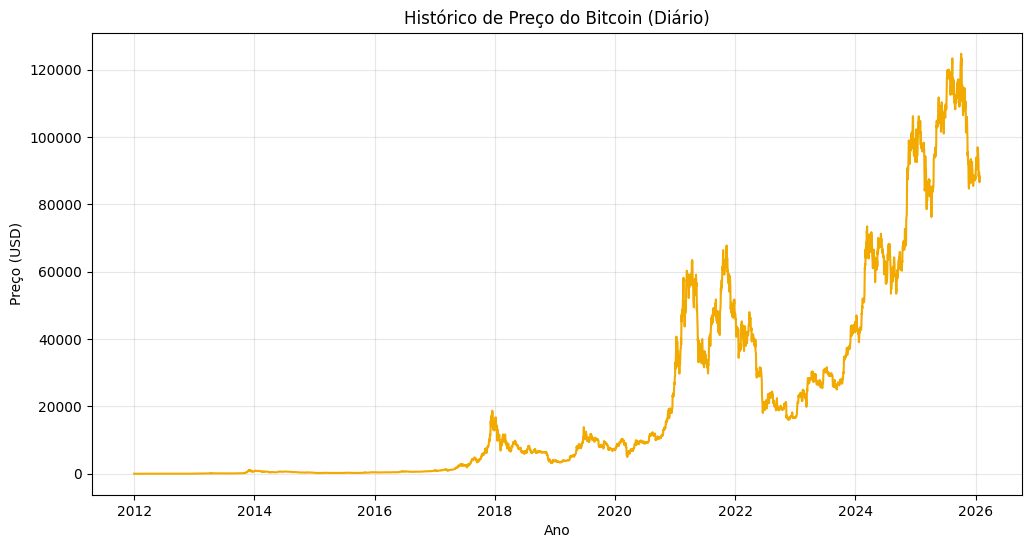

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df_daily['Close'], color='#f2a900') # Cor do Bitcoin!
plt.title('Histórico de Preço do Bitcoin (Diário)')
plt.xlabel('Ano')
plt.ylabel('Preço (USD)')
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# 1. Criando Lags (Preços de dias anteriores)
for i in range(1, 4):
    df_daily[f'lag_{i}'] = df_daily['Close'].shift(i)

# 2. Médias Móveis (Tendência de curto e médio prazo)
df_daily['ma_7'] = df_daily['Close'].rolling(window=7).mean()
df_daily['ma_21'] = df_daily['Close'].rolling(window=21).mean()

# 3. Volatilidade (Desvio padrão de 7 dias)
df_daily['std_7'] = df_daily['Close'].rolling(window=7).std()

# 4. Diferença percentual (Retorno diário)
df_daily['daily_return'] = df_daily['Close'].pct_change()

# 5. Criando o Target (O preço de AMANHÃ que queremos prever)
df_daily['target'] = df_daily['Close'].shift(-1)

# Remover as linhas com NaN criadas pelos deslocamentos (shifts)
df_daily.dropna(inplace=True)

print("Features criadas com sucesso!")
df_daily[['Close', 'lag_1', 'ma_7', 'target']].head()

Features criadas com sucesso!


Close  lag_1      ma_7  target
Timestamp                                 
2012-01-21   6.95   6.95  6.880000    6.83
2012-01-22   6.83   6.95  6.834286    6.52
2012-01-23   6.52   6.83  6.751429    6.55
2012-01-24   6.55   6.52  6.701429    6.00
2012-01-25   6.00   6.55  6.544286    6.27

In [7]:
# Definindo as colunas preditoras (X) e o alvo (y)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'lag_1', 'ma_7', 'ma_21', 'std_7', 'daily_return']
X = df_daily[features]
y = df_daily['target']

# Divisão cronológica (80/20)
split_index = int(len(df_daily) * 0.8)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Treino: {X_train.index.min()} até {X_train.index.max()}")
print(f"Teste: {X_test.index.min()} até {X_test.index.max()}")

Treino: 2012-01-21 00:00:00 até 2023-04-07 00:00:00
Teste: 2023-04-08 00:00:00 até 2026-01-25 00:00:00


In [11]:
# Configurando o modelo
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    importance_type='gain'
)

# Treino com Early Stopping (para evitar overfitting)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4095, number of used features: 10
[LightGBM] [Info] Start training from score 10104.656946
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's rmse: 25664.5	valid_0's l2: 6.58665e+08


LGBMRegressor(importance_type='gain', learning_rate=0.05, n_estimators=1000,
              objective='regression', random_state=42)

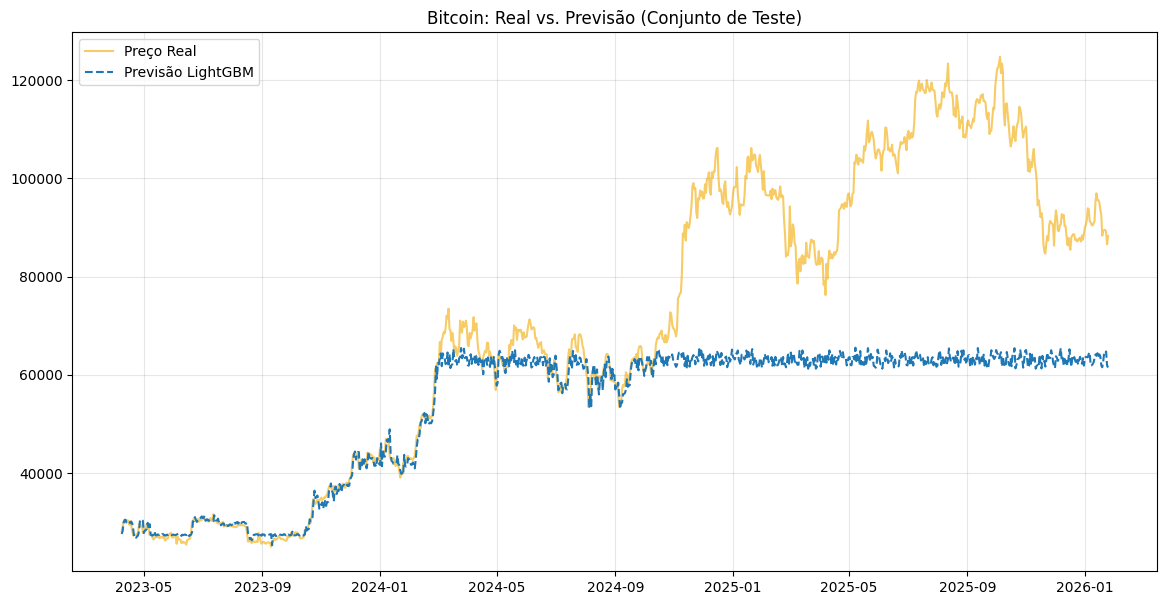

In [12]:
# 1. Fazendo as previsões no conjunto de teste
y_pred = model.predict(X_test)

# 2. Criando um DataFrame para comparar
df_results = pd.DataFrame({
    'Real': y_test,
    'Previsto': y_pred
}, index=y_test.index)

# 3. Plotando o gráfico
plt.figure(figsize=(14,7))
plt.plot(df_results['Real'], label='Preço Real', color='#f2a900', alpha=0.6)
plt.plot(df_results['Previsto'], label='Previsão LightGBM', color='#1f77b4', linestyle='--')
plt.title('Bitcoin: Real vs. Previsão (Conjunto de Teste)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Métricas de Avaliação:")
print(f"MAE:  US$ {mae:.2f}")
print(f"RMSE: US$ {rmse:.2f}")
print(f"R²:   {r2:.4f}")

Métricas de Avaliação:
MAE:  US$ 17212.93
RMSE: US$ 25664.48
R²:   0.2742


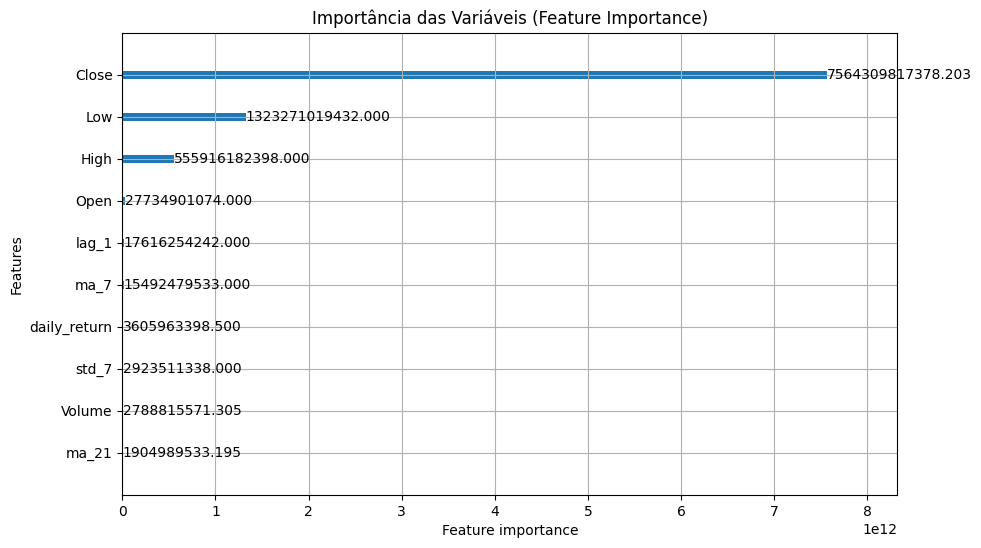

In [16]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain', figsize=(10,6))
plt.title('Importância das Variáveis (Feature Importance)')
plt.show()

In [17]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# 1. Definir o modelo base
lgbm = lgb.LGBMRegressor(objective='regression', random_state=42)

# 2. Criar a grade de parâmetros (Dica: não exagere no tamanho para não demorar horas)
param_grid = {
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [-1, 10, 20]
}

# 3. Configurar o validador para Séries Temporais (5 dobras)
tscv = TimeSeriesSplit(n_splits=5)

# 4. Configurar o Grid Search
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error', # Buscamos o menor erro
    verbose=1,
    n_jobs=-1 # Usa todos os núcleos do seu Mac
)

# 5. Executar a busca
print("Iniciando Grid Search... (isso pode levar alguns minutos)")
grid_search.fit(X_train, y_train)

Iniciando Grid Search... (isso pode levar alguns minutos)
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 685, number of used features: 10
[Ligh

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(objective='regression', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20],
                         'n_estimators': [100, 500, 1000],
                         'num_leaves': [20, 31, 50]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
# Ver os melhores parâmetros
print(f"Melhores Parâmetros: {grid_search.best_params_}")

# Pegar o melhor modelo treinado
best_model = grid_search.best_estimator_

# Fazer novas previsões
y_pred_optimized = best_model.predict(X_test)

# Comparar o novo RMSE com o anterior
from sklearn.metrics import mean_squared_error
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
print(f"Novo RMSE (Otimizado): US$ {rmse_opt:.2f}")

Melhores Parâmetros: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 20}
Novo RMSE (Otimizado): US$ 26088.27
